<center>
<img src="https://drive.google.com/uc?id=1f1gGVI-rxcHjA90WEGNvvtSXF1pAxQwg" alt="Fasilkom UI" width="300"/>

CSGE603130 • Kecerdasan Artifisial dan Sains Data Dasar

Semester Genap 2022/2023

Fakultas Ilmu Komputer, Universitas Indonesia

##**Lab *6*: *Imbalanced Classification***

###**Tenggat Waktu: 16 April 2023, 16.00 WIB**
</center>

####**Ketentuan:**

1. Dokumen *template* lab dengan format .ipynb dan dataset (jika dibutuhkan) telah disediakan di SCeLe
2. Jalankan kode pada dokumen .ipynb dan perhatikan dengan saksama apa yang potongan kode tersebut lakukan beserta dengan keluarannya. Jawablah **pertanyaan yang disisipkan** pada potongan program yang diberikan.
3. Dokumen Jupyter Notebook yang telah dilengkapi dengan jawaban dikumpulkan dengan format penamaan **Kelas_Lab6_NPM_Nama.ipynb**. Contoh: A_Lab6_2007654321_Budi.ipynb
4. Kumpulkan dokumen tersebut pada submisi yang telah disediakan di SCeLe sesuai dengan kelas masing-masing sebelum **16 April 2023, 16.00 WIB**. Keterlambatan pengumpulan akan dikenakan pinalti.
5. Lab ini dirancang sebagai **tugas mandiri**. Plagiarisme tidak diperkenankan dalam bentuk apapun. Adapun kolaborasi berupa diskusi (tanpa menyalin maupun mengambil jawaban orang lain) dan literasi masih diperbolehkan dengan mencantumkan kolaborator dan sumber.

# Pernyataan Integritas

Wajib diisi. Tanpa pernyataan integritas submisi akan dikenakan penalti.

In [1]:
# Isi dengan data diri Anda
NAMA = "IQBAL PAHLEVI AMIN"
KELAS = "KASDD - B"
NPM = "2106752281"

# Isi dengan NPM teman yang berdiskusi dengan Anda
KOLABORATOR = ['2106750742', '2106752224']

# Isi dengan sumber referensi yang Anda gunakan dalam mengerjakan
REFERENSI = [
    'https://machinelearningmastery.com/cost-sensitive-learning-for-imbalanced-classification/',
    'https://www.kaggle.com/code/residentmario/undersampling-and-oversampling-imbalanced-data'
]

In [2]:
PERNYATAAN_INTEGRITAS = "Saya, %s dari kelas %s dengan NPM %s, menyatakan bahwa seluruh jawaban pada pekerjaan ini murni saya kerjakan sendiri.\n\
Saya tidak mencontek jawaban, memberikan jawaban, maupun menyalin dari sumber manapun.\n \
\n\
Jika saya melanggar pernyataan tersebut, saya siap menerima konsekuensi apapun yang diberikan.\n   \
(%s)" % (NAMA, KELAS, NPM, NAMA)

print(PERNYATAAN_INTEGRITAS)

Saya, IQBAL PAHLEVI AMIN dari kelas KASDD - B dengan NPM 2106752281, menyatakan bahwa seluruh jawaban pada pekerjaan ini murni saya kerjakan sendiri.
Saya tidak mencontek jawaban, memberikan jawaban, maupun menyalin dari sumber manapun.
 
Jika saya melanggar pernyataan tersebut, saya siap menerima konsekuensi apapun yang diberikan.
   (IQBAL PAHLEVI AMIN)


This section is modified by Asisten Dosen KASDD Genap 2022/2023

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
from collections import Counter
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, NearMiss, TomekLinks
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from numpy import where

# Imbalanced Classification

Imbalanced classification merupakan suatu masalah dari klasifikasi ketika dataset training memiliki distribusi kelas yang tidak seimbang. Tingkat ketidakseimbangan dari distribusi kelas dapat beragam, contohnya:
*   Slight imbalance: ketidakseimbangan tingkat rendah (misalnya 4:6)
*   Severe imbalance: ketidakseimbangan tingkat tinggi (misalnya 1:100 atau lebih)

Dataset dengan distribusi kelas yang tidak seimbang ini dapat menyebabkan banyak kesalahan dalam proses pengklasifikasian kelas minoritas. Kelas minoritas akan lebih sulit untuk diprediksi karena hanya ada sedikit data pada kelas tersebut jika dibandingkan dengan kelas mayoritas. Data yang tidak seimbang ini dapat menyebabkan bias karena model klasifikasi akan cenderung berfokus untuk mempelajari karakteristik data pada kelas mayoritas dan cenderung mengabaikan kelas minoritas.

Salah satu pendekatan yang dapat dilakukan untuk mengatasi masalah ketidakseimbangan kelas ini adalah dengan men-sample (sampling) ulang dataset training. Terdapat dua pendekatan utama untuk men-sampling kumpulan data yang tidak seimbang, yaitu:
*   Oversampling: menduplikat contoh-contoh dari kelas minoritas
*   Undersampling: menghapus contoh-contoh dari kelas mayoritas

Selain sampling, terdapat juga teknik cost-sensitive learning yang akan dijelaskan setelahnya.



Di bawah ini merupakan contoh dari suatu **slight** imbalanced dataset.

In [4]:
# Pendefinisian dataset
X, y = make_classification(n_samples=10000,
                           n_features=2,
                           n_redundant=0,
                           n_clusters_per_class=1, 
                           weights=[0.6, 0.4], 
                           flip_y=0, 
                           random_state=1)

# Distribusi kelas yang terbuat
counter_y = Counter(y)
print(counter_y)

Counter({0: 6000, 1: 4000})


Dapat terlihat bahwa sudah terbentuk slight imbalanced dataset dengan perbandingan kelas mayoritas:minoritas senilai 6:4

Sekarang, kita akan mencoba melihat visualisasi dari dataset tersebut.

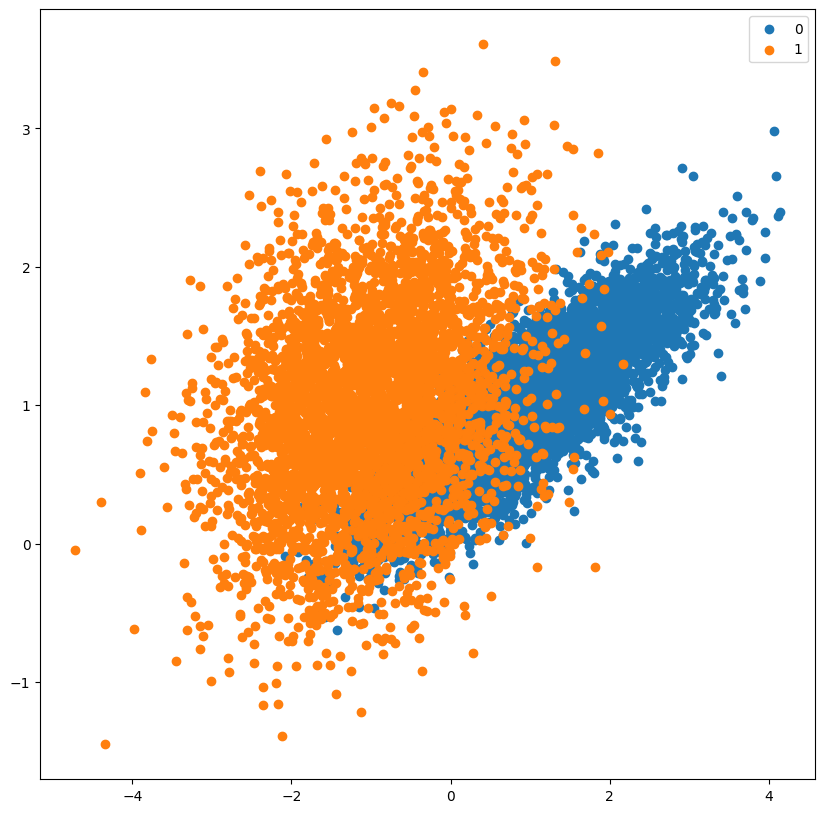

In [5]:
# Scatter plot dari dataset yang sudah di-generate di atas
pyplot.figure(figsize=(10, 10))

for label, _ in counter_y.items():
    row_ix = where(y == label)[0]
    pyplot.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
    pyplot.legend()
pyplot.show()

Dapat terlihat bahwa data minoritas yang ditandai dengan warna jingga tidak terlihat terlalu berbeda (dalam jumlah) dari data mayoritas yang ditandai dengan warna biru.

Untuk sekarang dan seterusnya pada lab ini, kita akan mencoba menggunakan severe imbalanced dataset. Di bawah ini merupakan contoh dari suatu **severe** imbalanced dataset.

In [6]:
# Pendefinisian dataset
X, y = make_classification(n_samples=10000,
                           n_features=2,
                           n_redundant=0,
                           n_clusters_per_class=1, 
                           weights=[0.99, 0.01], 
                           flip_y=0, 
                           random_state=2)

# Distribusi kelas yang terbuat
counter_y = Counter(y)
print(counter_y)

Counter({0: 9900, 1: 100})


Dapat terlihat bahwa sudah terbentuk severe imbalanced dataset dengan perbandingan kelas mayoritas:minoritas senilai 99:1

Sekarang, kita akan mencoba melihat visualisasi dari dataset tersebut.

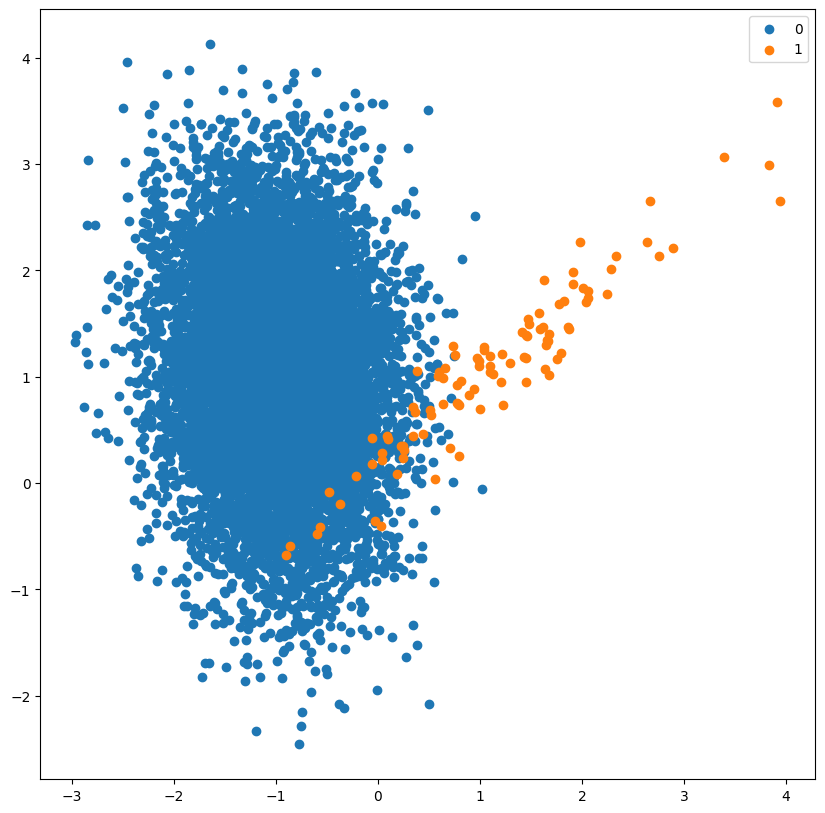

In [7]:
# Scatter plot dari dataset yang sudah di-generate di atas
pyplot.figure(figsize=(10, 10))

for label, _ in counter_y.items():
    row_ix = where(y == label)[0]
    pyplot.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
    pyplot.legend()
pyplot.show()

Dapat terlihat bahwa data minoritas yang ditandai dengan warna jingga berjumlah jauh lebih sedikit dibandingkan dengan data mayoritas yang ditandai dengan warna biru.

## Oversampling

Oversampling merupakan teknik yang digunakan untuk menduplikat atau menambah data kelas minoritas. Terdapat beberapa metode dari oversampling, di antaranya:
*   Random Oversampling
*   Synthetic Minority Oversampling Technique (SMOTE)
*   Borderline-SMOTE
*   Borderline Oversampling with SVM
*   Adaptive Synthetic Sampling (ADASYN)

Selanjutnya akan ditunjukkan bagaimana masing-masing metode dapat digunakan. Penjelasan teoritis yang lebih lengkap dari setiap metode dapat dibaca pada slide perkuliahan maupun dari internet.



### Random Oversampling

Secara acak memilih contoh-contoh dari kelas minoritas kemudian menduplikatnya pada dataset.

In [8]:
# Pendefinisian oversampling menggunakan metode Random
randomOverSample = RandomOverSampler(sampling_strategy='minority')

# Resample dataset
X_randover, y_randover = randomOverSample.fit_resample(X, y)

# Distribusi kelas yang terbuat
counter_y_randover = Counter(y_randover)
print(counter_y_randover)

Counter({0: 9900, 1: 9900})


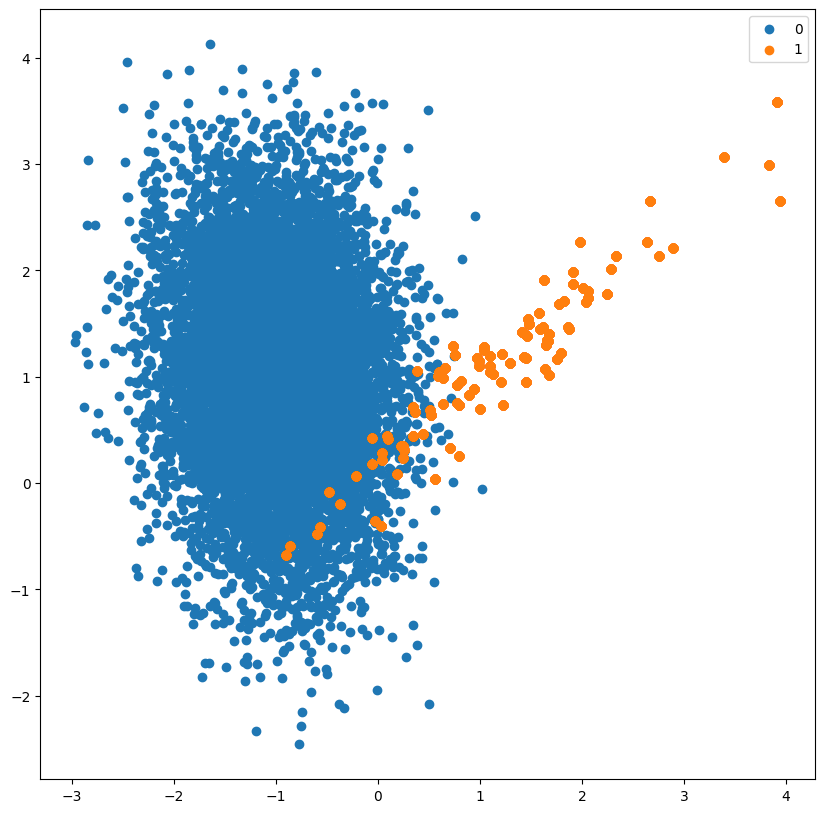

In [9]:
# Scatter plot dari dataset yang dibuat
pyplot.figure(figsize=(10, 10))

for label, _ in counter_y_randover.items():
    row_ix = where(y_randover == label)[0]
    pyplot.scatter(X_randover[row_ix, 0], X_randover[row_ix, 1], label=str(label))
    pyplot.legend()
pyplot.show()

### Synthetic Minority Oversampling Technique (SMOTE)

Membuat contoh kelas minoritas baru dari hasil sintesis contoh-contoh data kelas minoritas yang sudah ada.

In [10]:
# Pendefinisian oversampling menggunakan metode SMOTE
smote = SMOTE()

# Resample dataset
X_smote, y_smote = smote.fit_resample(X, y)

# Distribusi kelas yang terbuat
counter_y_smote = Counter(y_smote)
print(counter_y_smote)

Counter({0: 9900, 1: 9900})


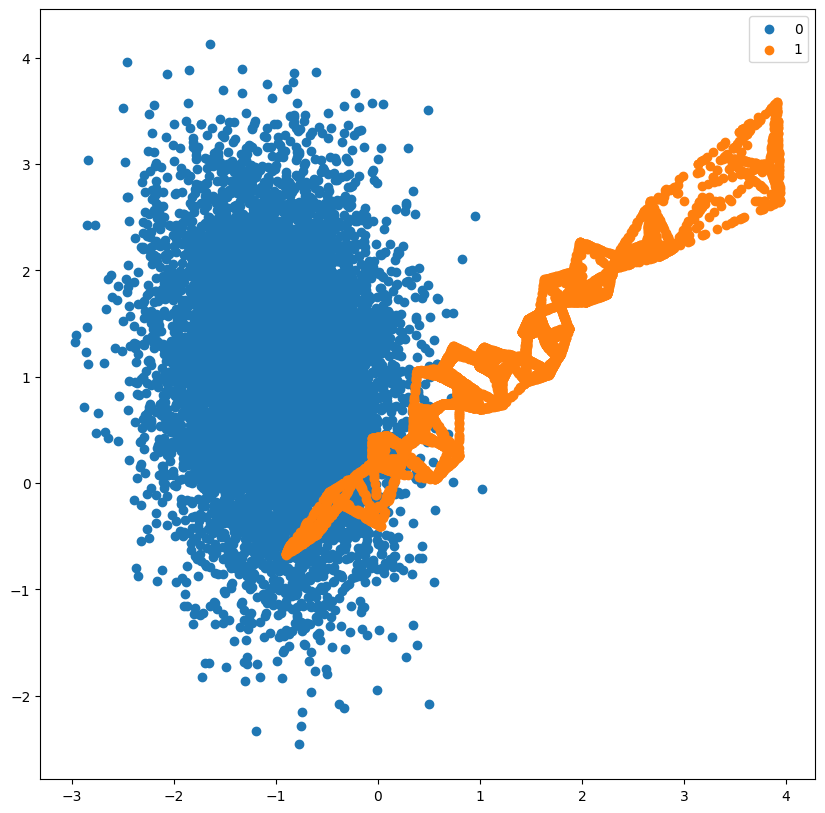

In [11]:
# scatter plot dari dataset yang dibuat
pyplot.figure(figsize=(10, 10))

for label, _ in counter_y_smote.items():
    row_ix = where(y_smote == label)[0]
    pyplot.scatter(X_smote[row_ix, 0], X_smote[row_ix, 1], label=str(label))
    pyplot.legend()
pyplot.show()

### Borderline-SMOTE

Variasi dari metode SMOTE. Berbeda dari SMOTE yang mana data sintetis terbuat secara acak antara dua data, Borderline-SMOTE hanya membuat data sintetis di sepanjang decision boundary antara dua kelas.

In [12]:
# Pendefinisian oversampling menggunakan metode Borderline SMOTE
borderline_smote = BorderlineSMOTE()

# Resample dataset
X_borderline_smote, y_borderline_smote = smote.fit_resample(X, y)

# Distribusi kelas yang terbuat
counter_y_borderline_smote = Counter(y_borderline_smote)
print(counter_y_borderline_smote)

Counter({0: 9900, 1: 9900})


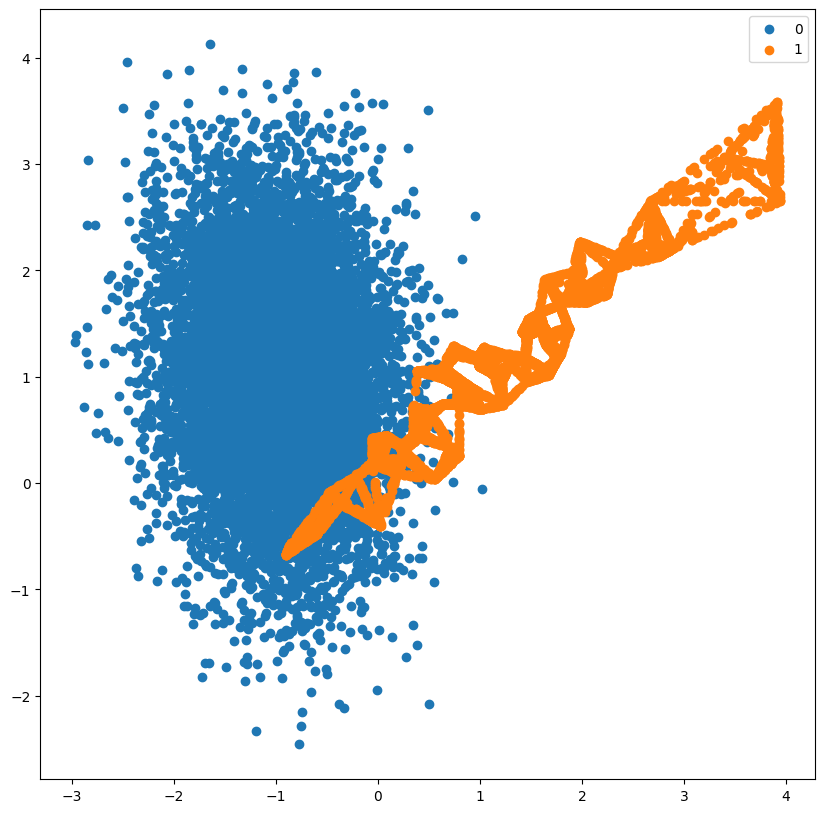

In [13]:
# scatter plot dari dataset yang dibuat
pyplot.figure(figsize=(10, 10))

for label, _ in counter_y_borderline_smote.items():
    row_ix = where(y_borderline_smote == label)[0]
    pyplot.scatter(X_borderline_smote[row_ix, 0], X_borderline_smote[row_ix, 1], label=str(label))
    pyplot.legend()
pyplot.show()

### Borderline Oversampling with SVM

Variasi dari metode Borderline-SMOTE. Perbedaan utama antara metode ini dengan SMOTE lainnya adalah bahwa alih-alih menggunakan k-NN untuk mengidentifikasi kesalahan klasifikasi di Borderline-SMOTE, metode ini menggunakan algoritma SVM.

In [14]:
# Pendefinisian oversampling menggunakan metode Borderline SMOTE SVM
svm_smote = SVMSMOTE()

# Resample dataset
X_svm_smote, y_svm_smote = svm_smote.fit_resample(X, y)

# Distribusi kelas yang terbuat
counter_y_svm_smote = Counter(y_svm_smote)
print(counter_y_svm_smote)

Counter({0: 9900, 1: 9900})


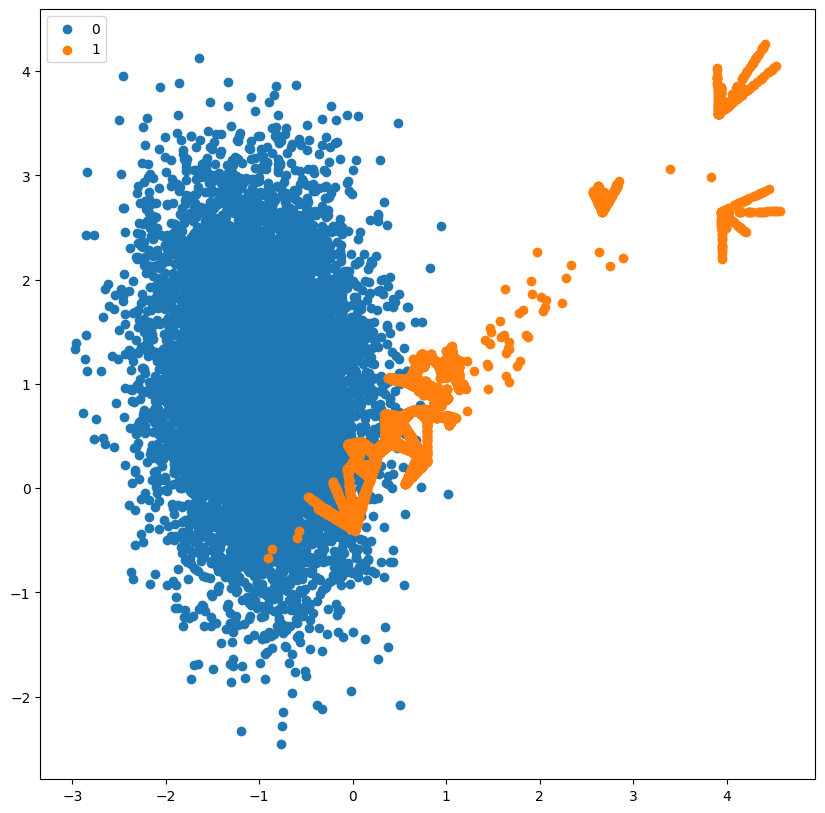

In [15]:
# Scatter plot dari dataset yang dibuat
pyplot.figure(figsize=(10, 10))

for label, _ in counter_y_svm_smote.items():
    row_ix = where(y_svm_smote == label)[0]
    pyplot.scatter(X_svm_smote[row_ix, 0],
                   X_svm_smote[row_ix, 1], label=str(label))
    pyplot.legend()
pyplot.show()

### Adaptive Synthetic Sampling (ADASYN)

Secara adaptif men-generate contoh-contoh kelas minoritas berdasarkan distribusinya.

In [16]:
# Pendefinisian oversampling menggunakan metode ADASYN
adasyn = ADASYN()

# Resample dataset
X_adasyn, y_adasyn = adasyn.fit_resample(X, y)

# Distribusi kelas yang terbuat
counter_y_adasyn = Counter(y_adasyn)
print(counter_y_adasyn)

Counter({0: 9900, 1: 9892})


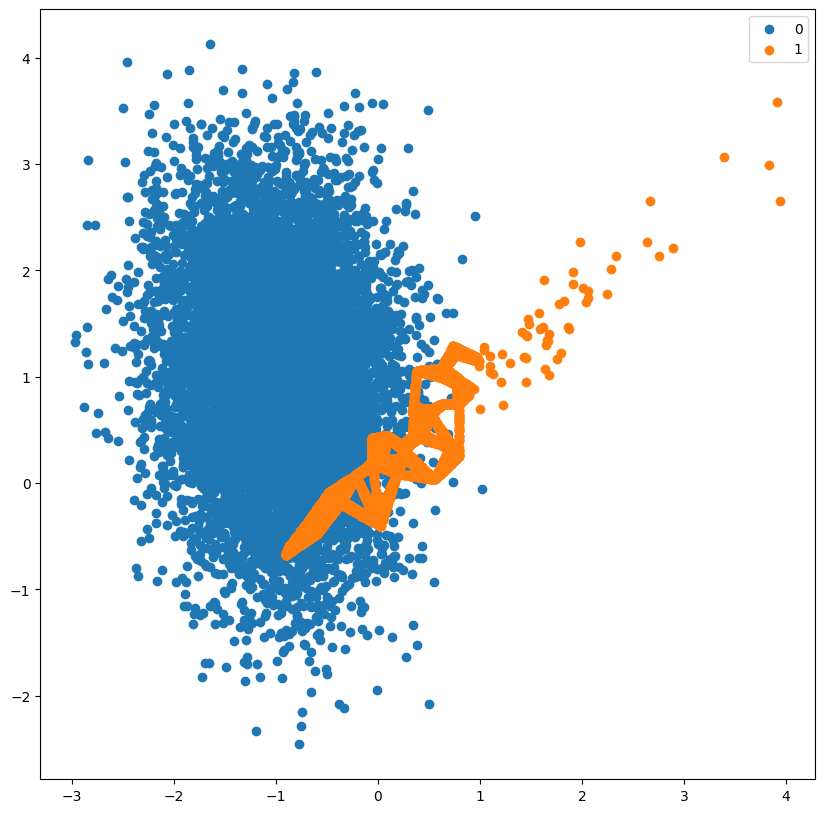

In [17]:
# Scatter plot dari dataset yang dibuat
pyplot.figure(figsize=(10, 10))

for label, _ in counter_y_adasyn.items():
    row_ix = where(y_adasyn == label)[0]
    pyplot.scatter(X_adasyn[row_ix, 0],
                   X_adasyn[row_ix, 1], label=str(label))
    pyplot.legend()
pyplot.show()

## Undersampling

Undersampling merupakan teknik yang digunakan untuk menghapus atau mengurangi data kelas mayoritas. Terdapat beberapa metode dari undersampling, di antaranya:
*   Random Undersampling
*   Near Miss Undersampling (versi 1, 2, dan 3)
*   Tomek Link

Selanjutnya akan ditunjukkan bagaimana masing-masing metode dapat digunakan. Penjelasan teoritis yang lebih lengkap dari setiap metode dapat dibaca pada slide perkuliahan maupun dari internet.

### Random Undersampling

Secara acak memilih contoh-contoh dari kelas mayoritas kemudian menguranginya dari dataset.

In [18]:
# Pendefinisian undersampling menggunakan metode random
undersample = RandomUnderSampler(sampling_strategy='majority')

# Resample dataset
X_randunder, y_randunder = undersample.fit_resample(X, y)

# Distribusi kelas yang terbuat
counter_y_randunder = Counter(y_randunder)
print(counter_y_randunder)

Counter({0: 100, 1: 100})


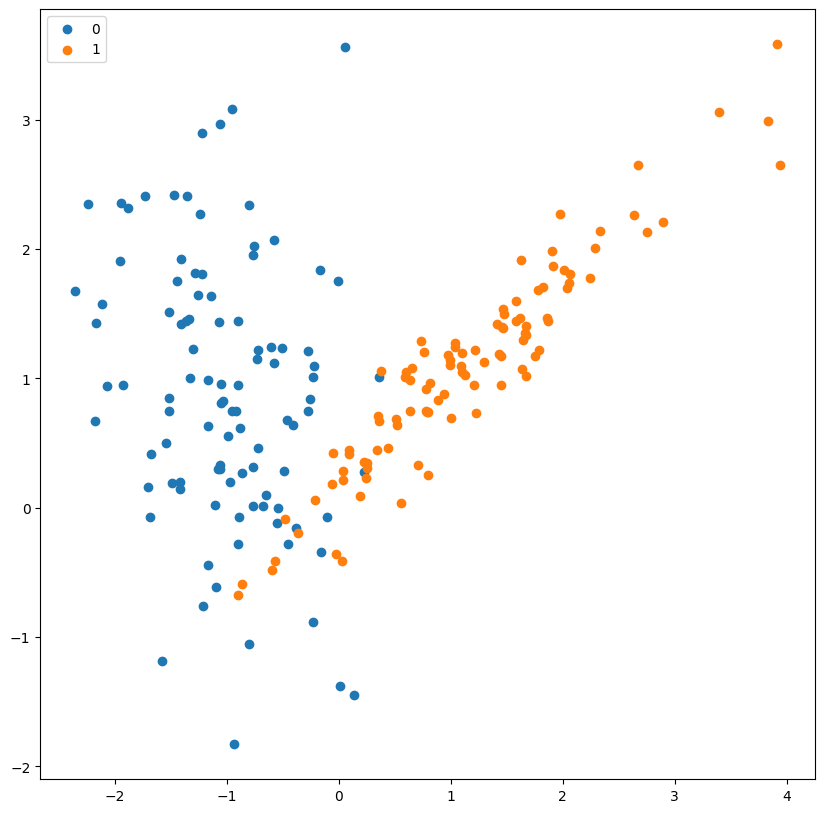

In [19]:
# scatter plot of examples by class label
pyplot.figure(figsize=(10, 10))

for label, _ in counter_y_randunder.items():
    row_ix = where(y_randunder == label)[0]
    pyplot.scatter(X_randunder[row_ix, 0],
                   X_randunder[row_ix, 1], label=str(label))
    pyplot.legend()
pyplot.show()

### Near Miss Undersampling

Sebuah koleksi metode undersampling yang memilih contoh berdasarkan jarak dari contoh kelas mayoritas ke contoh kelas minoritas. Terdapat tiga versi yang masing-masing akan ditunjukkan di bawah.

#### NearMiss-1

Memilih sampel dari kelas mayoritas yang rerata jarak minimumnya ke tiga kelas minoritas terdekat merupakan yang terkecil.

In [20]:
# Pendefinisian undersampling menggunakan metode nearmiss-1
nearmiss = NearMiss()

# Resample dataset
X_nearmiss, y_nearmiss = nearmiss.fit_resample(X, y)

# Distribusi kelas yang terbuat
counter_y_nearmiss = Counter(y_nearmiss)
print(counter_y_nearmiss)

Counter({0: 100, 1: 100})


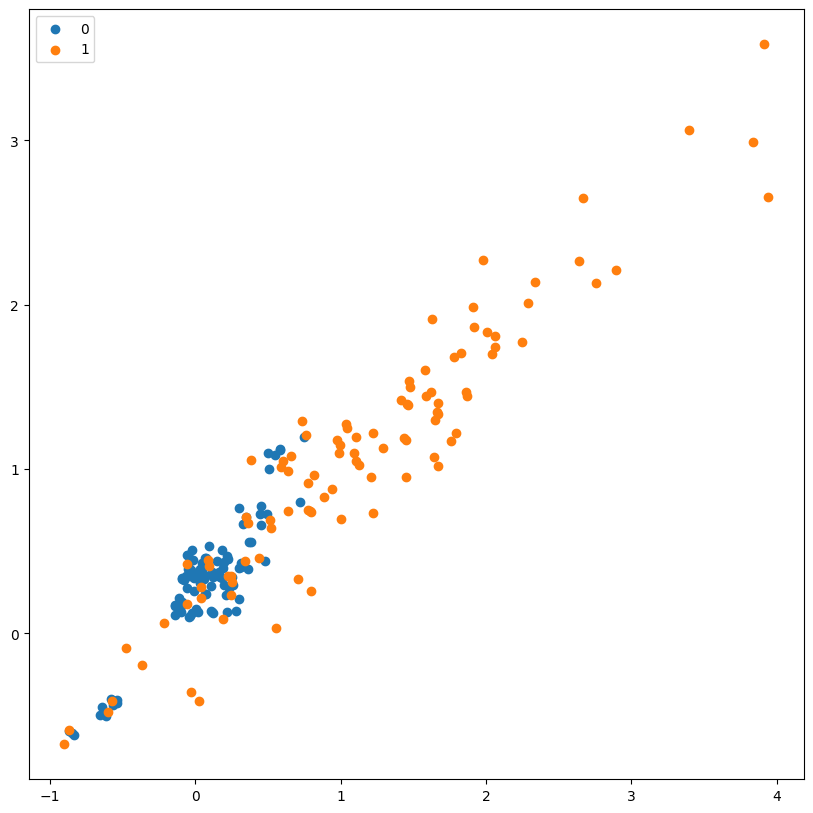

In [21]:
# scatter plot of examples by class label
pyplot.figure(figsize=(10, 10))

for label, _ in counter_y_nearmiss.items():
    row_ix = where(y_nearmiss == label)[0]
    pyplot.scatter(X_nearmiss[row_ix, 0],
                   X_nearmiss[row_ix, 1], label=str(label))
    pyplot.legend()
pyplot.show()

#### NearMiss-2

Memilih sampel dari kelas mayoritas yang rerata jarak minimumnya ke tiga kelas minoritas terjauh merupakan yang terkecil.

In [22]:
# Pendefinisian undersampling menggunakan metode nearmiss-2
nearmiss = NearMiss(version=2)

# Resample dataset
X_nearmiss, y_nearmiss = nearmiss.fit_resample(X, y)

# Distribusi kelas yang terbuat
counter_y_nearmiss = Counter(y_nearmiss)
print(counter_y_nearmiss)

Counter({0: 100, 1: 100})


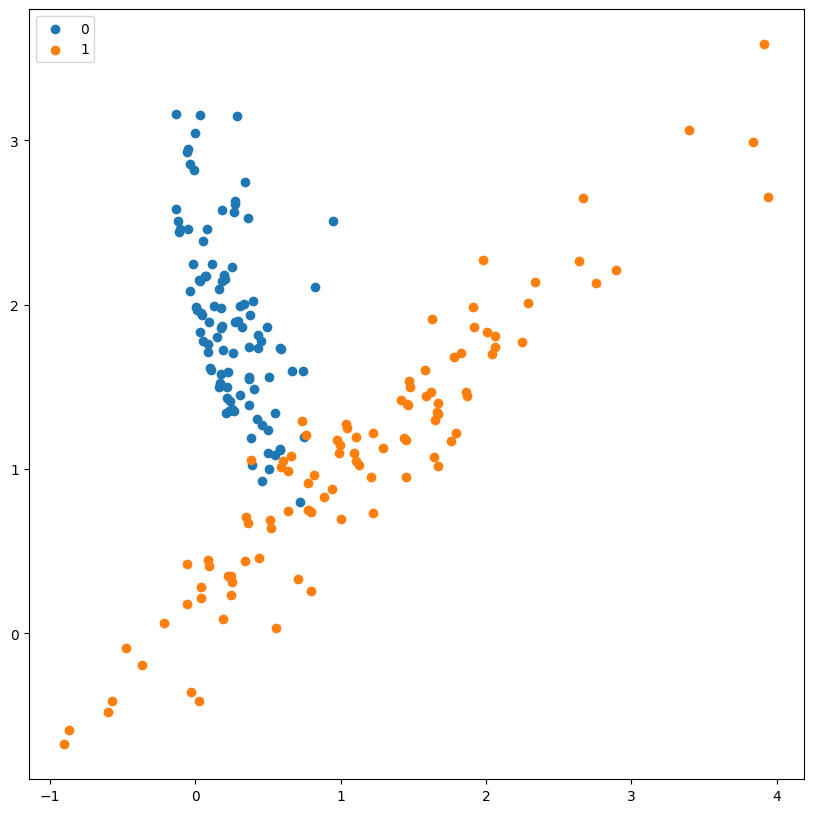

In [23]:
# scatter plot of examples by class label
pyplot.figure(figsize=(10, 10))

for label, _ in counter_y_nearmiss.items():
    row_ix = where(y_nearmiss == label)[0]
    pyplot.scatter(X_nearmiss[row_ix, 0],
                   X_nearmiss[row_ix, 1], label=str(label))
    pyplot.legend()
pyplot.show()

#### NearMiss-3

Memilih sampel dari kelas mayoritas yang jarak minimumnya ke setiap kelas minoritas merupakan yang terkecil.

In [24]:
# Pendefinisian undersampling menggunakan metode nearmiss-3
nearmiss = NearMiss(version=3)

# Resample dataset
X_nearmiss, y_nearmiss = nearmiss.fit_resample(X, y)

# Distribusi kelas yang terbuat
counter_y_nearmiss = Counter(y_nearmiss)
print(counter_y_nearmiss)

Counter({1: 100, 0: 84})


c:\Users\IQBAL\AppData\Local\Programs\Python\Python310\lib\site-packages\imblearn\under_sampling\_prototype_selection\_nearmiss.py:203: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn(


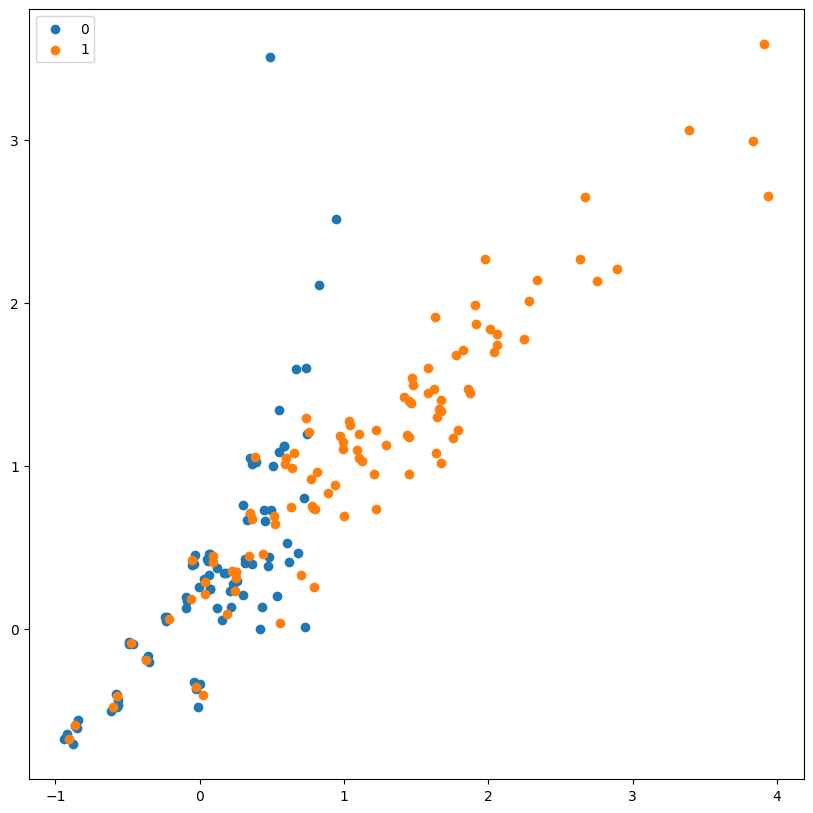

In [25]:
# scatter plot of examples by class label
pyplot.figure(figsize=(10, 10))

for label, _ in counter_y_nearmiss.items():
    row_ix = where(y_nearmiss == label)[0]
    pyplot.scatter(X_nearmiss[row_ix, 0],
                   X_nearmiss[row_ix, 1], label=str(label))
    pyplot.legend()
pyplot.show()

### Tomek Link for Undersampling

Menghapus sampel kelas mayoritas yang termasuk sebagai Tomek Link.

In [26]:
# Pendefinisian undersampling menggunakan metode Tomek Link
tomek = TomekLinks()

# Resample dataset
X_tomek, y_tomek = tomek.fit_resample(X, y)

# Distribusi kelas yang terbuat
counter_y_tomek = Counter(y_tomek)
print(counter_y_tomek)

Counter({0: 9883, 1: 100})


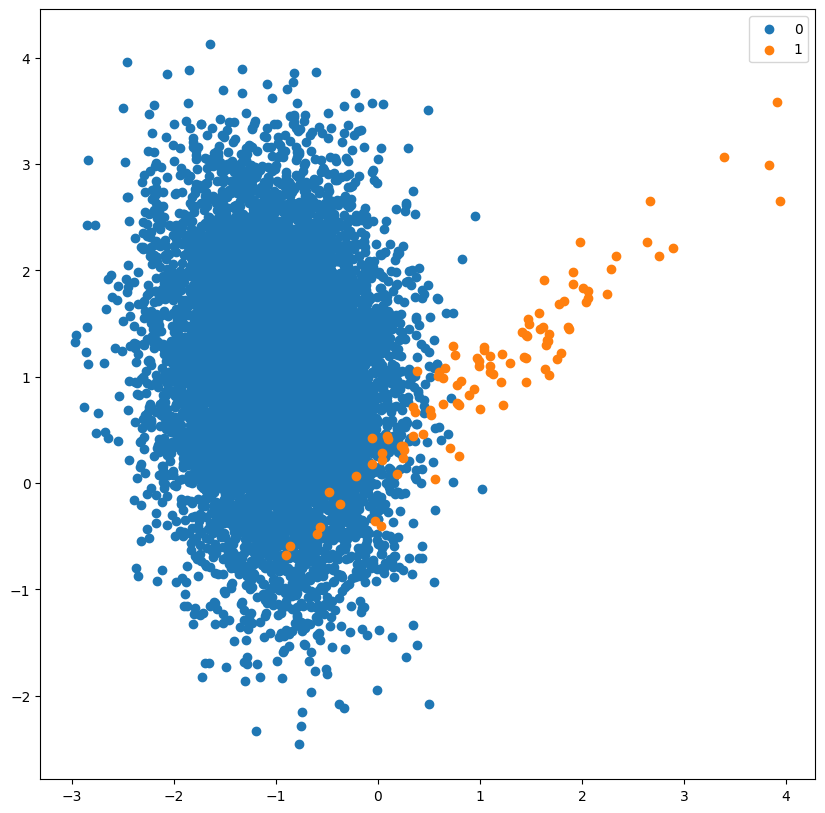

In [27]:
pyplot.figure(figsize=(10, 10))

for label, _ in counter_y_tomek.items():
    row_ix = where(y_tomek == label)[0]
    pyplot.scatter(X_tomek[row_ix, 0],
                   X_tomek[row_ix, 1], label=str(label))
    pyplot.legend()
pyplot.show()

## Cost Sensitive Learning

Sebagian besar algoritma machine learning berasumsi bahwa semua kesalahan klasifikasi yang dibuat oleh suatu model memiliki bobot yang sama. Namun, seringkali asumsi ini tidak benar untuk masalah imbalanced classification di mana kehilangan kasus kelas positif atau kelas minoritas dapat lebih buruk daripada salah mengklasifikasikan contoh dari kelas negatif atau kelas mayoritas. Contoh sehari-harinya seperti mendeteksi email spam, mendiagnosis kondisi medis, atau mengidentifikasi penipuan. Dalam semua kasus tersebut, false negative lebih buruk atau lebih mahal 'harganya' daripada false positive.

Penentuan atau pembobotan cost matrix untuk kasus-kasus tersebut seringkali melibatkan para ahli di bidang masing-masing permasalahan, contohnya seperti ekonom untuk menentukan monetary cost dari sebuah kasus pembobolan bank. Namun, tidak jarang juga untuk menggunakan kebalikan dari distribusi kelas yang ada untuk pembobotannya. Sebagai contoh, distribusi kelas minoritas:mayoritas dari suatu dataset adalah 1:100. Kebalikan dari rasio tersebut dapat digunakan untuk pembobotannya (1 untuk kelas mayoritas dan 100 untuk kelas minoritas)

Terdapat tiga kategori utama dari cost-sensitive methods yang paling relevan untuk imbalanced learning, yaitu cost-sensitive resampling, cost-sensitive algorithms, dan cost-sensitive ensembles.

Penjelasan teoritis lebih lengkap dari cost-sensitive learning dapat dibaca pada slide kuliah maupun dari sumber internet :)

### Cost Sensitive Decision Tree

Sebagai contoh dari cost-sensitive algorithm, kita akan menggunakan model Decision Tree yang Anda sudah pernah pelajari sebelumnya. 

Pertama, kita akan mendefinisikan bobot untuk false positive dan false negative-nya. Asumsikan bobot untuk FP adalah 1 dan bobot untuk FN adalah 99.

In [28]:
# Pendefinisian bobot dan model
weights = {0:1.0, 1:99.0}
model_1 = DecisionTreeClassifier(class_weight=weights)

Selanjutnya, evaluasi model untuk mengetahui performanya

In [29]:
# Pendefinisian evaluasi
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

# Performa
scores = cross_val_score(model_1, X, y, scoring='roc_auc', cv=cv)
print('Mean ROC AUC Model Weighted: %.3f' % np.mean(scores))

Mean ROC AUC Model Weighted: 0.845


Sekarang, mari kita bandingkan dengan versi unweighted-nya

In [30]:
# Pendefinisian model
model_2 = DecisionTreeClassifier()
# Pendefinisian evaluasi
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
# Performa
scores = cross_val_score(model_2, X, y, scoring='roc_auc', cv=cv)
print('Mean ROC AUC Model Unweighted: %.3f' % np.mean(scores))

Mean ROC AUC Model Unweighted: 0.843


Terlihat bahwa skor mean ROC AUC sedikit lebih baik pada versi weighted dibandingkan versi unweighted

## Pipeline

Pipeline yang telah disediakan oleh library imbalanced-learn dapat digunakan untuk memastikan bahwa sampling hanya dilakukan pada data training dan bukan pada data testing. Selain itu, kita juga menggunakan stratified k-fold agar rasio kelas tetap terjaga di setiap fold-nya. Lebih lengkapnya dapat dibaca pada slide perkuliahan maupun [dokumentasi berikut](https://imbalanced-learn.org/stable/references/generated/imblearn.pipeline.Pipeline.html).

Sekarang kita akan mencoba menerapkan pipeline untuk random undersampling pada model decision tree dan severe imbalanced dataset yang disediakan di awal.

In [31]:
# Pendefinisian
steps = [
    ('under', RandomUnderSampler(sampling_strategy='majority')), 
    ('model', DecisionTreeClassifier())
]
pipeline = Pipeline(steps=steps)

# Evaluasi
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
scores = cross_val_score(pipeline, X, y, scoring='f1_micro', cv=cv, n_jobs=-1)
score = np.mean(scores)

# Tampilkan 
print('F-measure: %.3f' % score)

F-measure: 0.929


# Latihan

## Dataset

Tugas ini menggunakan imbalanced dataset Insurance dari [Kaggle](https://www.kaggle.com/datasets/arashnic/imbalanced-data-practice?resource=download) yang telah dimodifikasi.

Dataset ini digunakan untuk memprediksi apakah seorang pelanggan tertarik untuk membeli asuransi kendaraan. Prediksi ini akan sangat bermanfaat bagi perusahaan karena mereka dapat merencanakan strategi komunikasi dan pemasarannya untuk menjangkau pelanggan tersebut dan mengoptimalkan model bisnis dan pendapatannya.

Dataset memiliki informasi terkait:
*   Demographics (gender, age, region 
code type),
*   Vehicles (vehicle Age, damage),
*   Policy (premium, sourcing channel) etc.

In [32]:
# Read dataset insurance.csv dan tampilkan dataset tersebut
df = pd.read_csv('insurance.csv')
df.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Female,26,1,28.0,0,1-2 Year,No,35566.0,124.0,284,0
1,Male,25,1,29.0,1,< 1 Year,No,37498.0,152.0,95,0
2,Male,70,1,28.0,1,1-2 Year,No,67473.0,26.0,85,0
3,Male,29,1,17.0,1,< 1 Year,No,31468.0,152.0,14,0
4,Female,49,1,48.0,0,1-2 Year,Yes,2630.0,15.0,193,0


## Data Awal

a. Ambil data {Annual_Premium & Age} untuk X dan data {Response} untuk y 

(mahasiswa juga diperbolehkan melakukan eksplorasi dengan pasangan fitur lain untuk X)

In [123]:
X = df[['Annual_Premium', 'Age']].to_numpy()
y = df['Response'].to_numpy()

b. Hitung jumlah masing-masing target (Hint: Counter)

In [124]:
counter_y = Counter(y)
print(counter_y)

Counter({0: 10000, 1: 100})


c. Lakukan visualisasi data

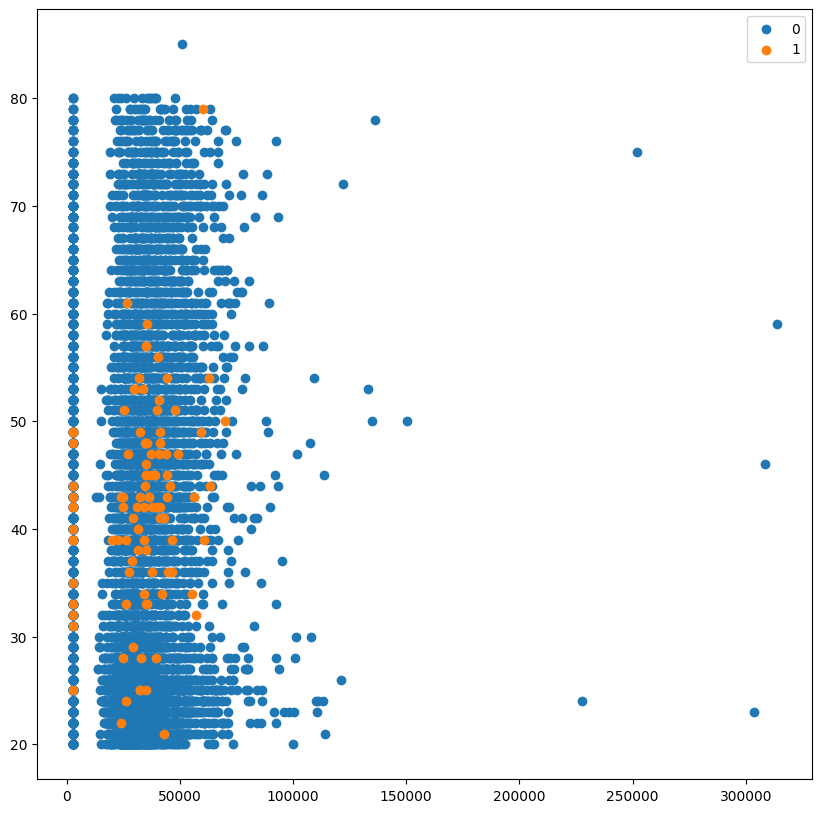

In [125]:
# Scatter plot dari dataset
pyplot.figure(figsize=(10, 10))

for label, _ in counter_y.items():
    row_ix = where(y == label)[0]
    pyplot.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
    pyplot.legend()
pyplot.show()

Untuk keempat kombinasi model dan teknik yang akan kita coba selanjutnya, semuanya akan menggunakan model Decision Tree yang sudah pernah Anda pelajari pada materi sebelumnya :D

## Model Standar

1. Lakukan klasifikasi pada data menggunakan:

*   model decision tree
*   menerapkan repeated stratified k-fold cross validation

*mahasiswa boleh menggunakan pipeline ataupun tidak


a. Definisikan model (dan pipeline apabila menggunakan)

In [126]:
dt1 = DecisionTreeClassifier()

b. Evaluasi menggunakan repeated stratified K-Fold

In [127]:
# Pendefinisian evaluasi
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

# Performa
roc_auc = cross_val_score(dt1, X, y, scoring='roc_auc', cv=cv)
f1 = cross_val_score(dt1, X, y, scoring='f1_micro', cv=cv)

c. Tampilkan metrik evaluasi berupa ROC AUC dan F1-Score

In [128]:
print(f'Mean ROC AUC: {np.mean(roc_auc):.3f}')
print(f'Mean F1 Micro Score: {np.mean(f1):.3f}')

Mean ROC AUC: 0.534
Mean F1 Micro Score: 0.983


## Model dengan Teknik Oversampling

### Percobaan Oversampling

Dari metode-metode oversampling yang ada, pilihlah dua metode oversampling sesuai keinginan Anda untuk dipelajari.

1. Metode oversampling 1

a. Lakukan Oversample pada X dan y dengan metode pertama yang dipilih

In [129]:
# oversampling menggunakan SMOTE
smote = SMOTE()

# Resample dataset
X_smote, y_smote = smote.fit_resample(X, y)

b. Hitung jumlah (counter) target setelah di-oversample

In [130]:
# Distribusi kelas yang terbuat
counter_y_smote = Counter(y_smote)
print(counter_y_smote)

Counter({0: 10000, 1: 10000})


c. Lakukan visualisasi pada data setelah di-oversample

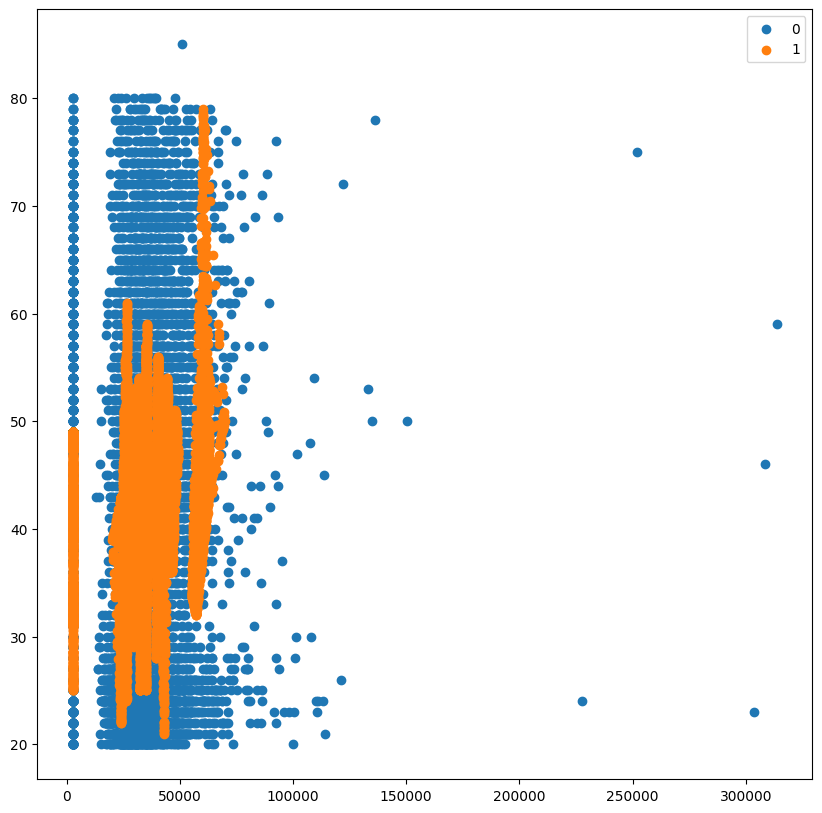

In [131]:
# scatter plot dari dataset yang dibuat
pyplot.figure(figsize=(10, 10))

for label, _ in counter_y_smote.items():
    row_ix = where(y_smote == label)[0]
    pyplot.scatter(X_smote[row_ix, 0], X_smote[row_ix, 1], label=str(label))
    pyplot.legend()
pyplot.show()

2. Metode Oversampling 2

a. Lakukan Oversample pada X dan y dengan metode kedua yang dipilih

In [132]:
# Pendefinisian oversampling menggunakan metode Borderline SMOTE SVM
svm_smote = SVMSMOTE()

# Resample dataset
X_svm_smote, y_svm_smote = svm_smote.fit_resample(X, y)

b. Hitung jumlah (counter) target setelah di-oversample

In [133]:
# Distribusi kelas yang terbuat
counter_y_svm_smote = Counter(y_svm_smote)
print(counter_y_svm_smote)

Counter({0: 10000, 1: 5255})


c. Lakukan visualisasi pada data setelah di-oversample

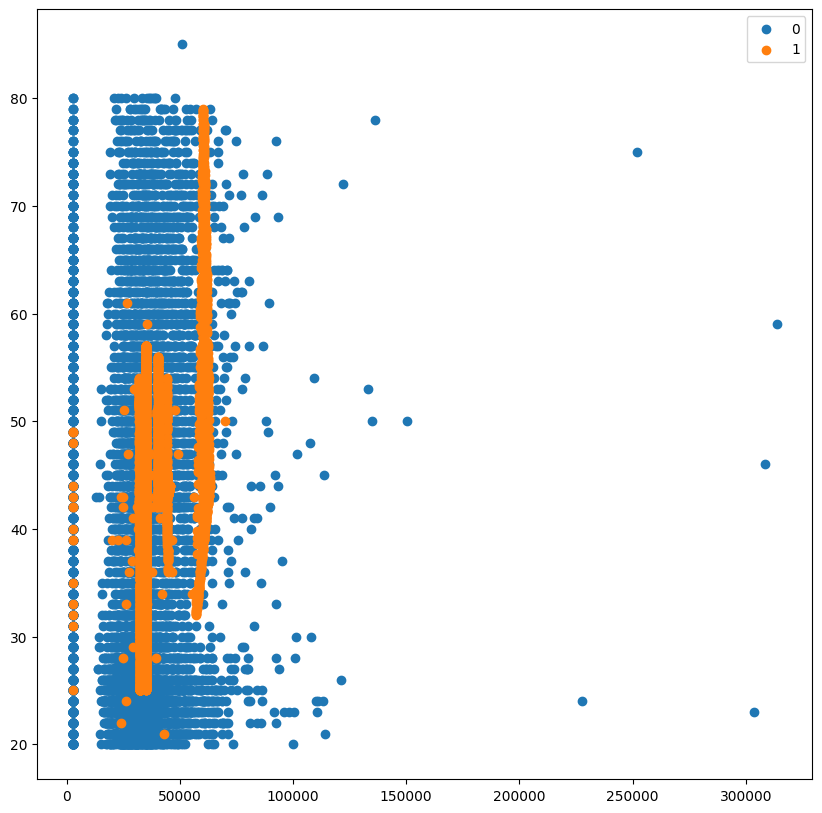

In [134]:
# Scatter plot dari dataset yang dibuat
pyplot.figure(figsize=(10, 10))

for label, _ in counter_y_svm_smote.items():
    row_ix = where(y_svm_smote == label)[0]
    pyplot.scatter(X_svm_smote[row_ix, 0],X_svm_smote[row_ix, 1], label=str(label))
    pyplot.legend()
pyplot.show()

3. Adakah perbedaan yang Anda lihat dari pengamatan terhadap hasil visualisasi kedua metode tersebut? Jelaskan!

> terdapat perbedaan antara hasil oversampling menggunakan SMOTE dan SVM SMOTE. SMOTE menghasilkan data yang lebih banyak (10000) dibandingkan dengan SVM SMOTE (5255). <br><br>
> Hal ini dikarenakan SMOTE menghasilkan data baru dengan cara mengambil data minoritas dengan mengambil sampel acak dari tetangga terdekat untuk setiap sampel minoritas dan membuat sampel baru dengan mengambil perbedaan antara sampel minoritas dan sampel yang sudah ada. kemudian menambahkan perbedaan itu ke sampel minoritas untuk membuat sampel sintetis.<br><br>
> sedangkan SVM SMOTE bekerja menggunakan teknik SVM untuk menghasilkan data baru. SVM SMOTE berusaha menghasilkan sampel sintetis yang terletak di sekitar hyperplane yang dibentuk oleh data minoritas.<br><br>
> dengan kata lain, SVM SMOTE mencoba menambahkan sampel sintetis yang lebih masuk akal karena berada di sekitar hyperplane yang dibentuk oleh data minoritas. sehingga ia menghasilkan data yang lebih sedikit dibandingkan dengan SMOTE.

### Pemodelan untuk Klasifikasi

1. Lakukan klasifikasi pada data menggunakan:
*   Pipeline
*   **salah satu** metode oversampling yang Anda pilih sebelumnya
*   model Decision Tree
*   menerapkan repeated stratified k-fold cross validation



a. Sebutkan metode yang Anda pilih dan definisikan model yang diminta

In [135]:
# saya memutuskan untuk menggunakan metode SMOTE
smote = SMOTE()

# model
dt = DecisionTreeClassifier()

b. Definisikan pipeline

In [136]:
steps = [
    ('oversampling', smote),
    ('model', dt)
]
pipeline = Pipeline(steps=steps)

c. Evaluasi pipeline menggunakan repeated stratified K-Fold

In [137]:
# Evaluasi
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
# roc auc
roc_auc = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
score_roc_auc = np.mean(roc_auc)
# f1 score
f1 = cross_val_score(pipeline, X, y, scoring='f1_micro', cv=cv, n_jobs=-1)
score_f1 = np.mean(roc_auc)

d. Tampilkan metrik evaluasi berupa ROC AUC dan F1-Score

In [138]:
print(f'Mean ROC AUC score: {score_roc_auc:.3f}')
print(f'Mean F1 Micro Score: {score_f1:.3f}')

Mean ROC AUC score: 0.579
Mean F1 Micro Score: 0.579


## Model dengan Teknik Undersampling

### Percobaan Undersampling

Dari metode-metode undersampling yang ada, pilihlah dua metode undersampling sesuai keinginan Anda untuk dipelajari.

1. Metode undersampling 1

a. Lakukan Undersample pada X dan y dengan metode pertama yang dipilih

In [139]:
# Pendefinisian undersampling menggunakan metode random
undersample = RandomUnderSampler(sampling_strategy='majority')

# Resample dataset
X_randunder, y_randunder = undersample.fit_resample(X, y)

b. Hitung jumlah (counter) target setelah di-undersample

In [140]:
# Distribusi kelas yang terbuat
counter_y_randunder = Counter(y_randunder)
print(counter_y_randunder)

Counter({0: 100, 1: 100})


c. Lakukan visualisasi pada data setelah di-undersample

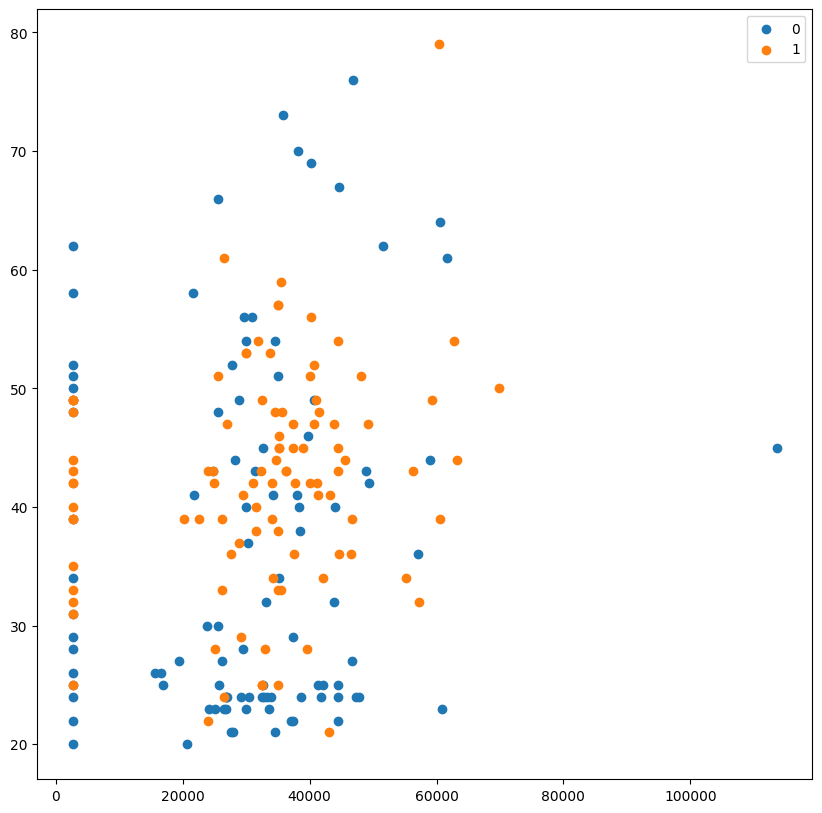

In [141]:
# scatter plot of examples by class label
pyplot.figure(figsize=(10, 10))

for label, _ in counter_y_randunder.items():
    row_ix = where(y_randunder == label)[0]
    pyplot.scatter(X_randunder[row_ix, 0], X_randunder[row_ix, 1], label=str(label))
    pyplot.legend()
pyplot.show()

2. Metode undersampling 2

a. Lakukan Undersample pada X dan y dengan metode kedua yang dipilih

In [142]:
# Pendefinisian undersampling menggunakan metode nearmiss-2
nearmiss = NearMiss(version=2)

# Resample dataset
X_nearmiss, y_nearmiss = nearmiss.fit_resample(X, y)

b. Hitung jumlah (counter) target setelah di-undersample

In [143]:
# Distribusi kelas yang terbuat
counter_y_nearmiss = Counter(y_nearmiss)
print(counter_y_nearmiss)

Counter({0: 100, 1: 100})


c. Lakukan visualisasi pada data setelah di-undersample

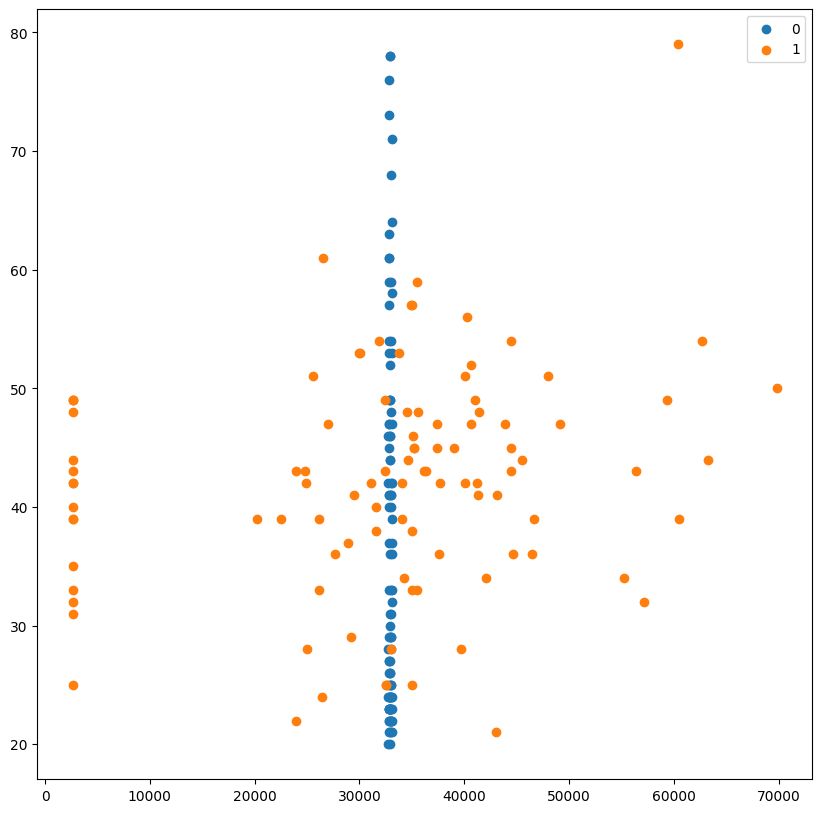

In [144]:
# scatter plot of examples by class label
pyplot.figure(figsize=(10, 10))

for label, _ in counter_y_nearmiss.items():
    row_ix = where(y_nearmiss == label)[0]
    pyplot.scatter(X_nearmiss[row_ix, 0], X_nearmiss[row_ix, 1], label=str(label))
    pyplot.legend()
pyplot.show()

3. Adakah perbedaan yang Anda lihat dari pengamatan terhadap hasil visualisasi kedua metode tersebut? Jelaskan!

> Terdapat perbedaan persebaran data hasil undersampling menggunakan Random Undersampling dan Nearmiss 2. Dapat dilihat bahwa data pada hasil Random Undersampling lebih bervariasi daripada data hasil Nearmiss 2 yang lebih terpusat (membentuk garis lurus/mendekati linear). <br><br>
> Hal ini disebabkan karena Random Undersampling bekerja dengan cara mengurangi jumlah sampel dari kelas mayoritas secara acak hingga jumlah data kelas mayoritas dan minoritas sama. <br><br>
> sedangkan Nearmiss 2 bekerja dengan cara memilih sample dari kelas mayoritas yang berdekatan dengan sample dari kelas minoritas menggunakan jarak Euclidean atau pun manhattan. teknik ini mengevaluasi jarak antara sampel minoritas dan sampel mayoritas terdekat. kemudian mengambil sampel mayoritas yang berdekatan dengan sampel minoritas tersebut. hal ini bertujuan untuk mendapatkan data mayoritas yang memiliki karakteristik mirip dengan kelas minortias <br><br>
> perbedaan utama dari kedua metode tersebut adalah pada cara pengambilan data. Random Undersampling mengambil data secara acak, sedangkan Nearmiss 2 mengambil data berdasarkan jarak terdekat dengan kelas minoritas.

### Pemodelan untuk Klasifikasi

1. Lakukan klasifikasi pada data menggunakan:
*   Pipeline
*   **salah satu** metode undersampling yang Anda pilih sebelumnya
*   model Decision Tree
*   menerapkan repeated stratified k-fold cross validation

a. Sebutkan metode yang Anda pilih dan definisikan model yang diminta

In [145]:
# metode yang saya pilih adalah Random Undersampling
undersample = RandomUnderSampler(sampling_strategy='majority')
# model
dt2 = DecisionTreeClassifier()

b. Definisikan pipeline

In [146]:
steps = [
    ('undersampling', undersample),
    ('model', dt2)
]
pipeline = Pipeline(steps=steps)

c. Evaluasi pipeline menggunakan repeated stratified K-Fold

In [147]:
# Evaluasi
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
# roc auc
roc_auc = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
score_roc_auc = np.mean(roc_auc)
# f1 score
f1 = cross_val_score(pipeline, X, y, scoring='f1_micro', cv=cv, n_jobs=-1)
score_f1 = np.mean(roc_auc)

d. Tampilkan metrik evaluasi berupa ROC AUC dan F1-Score

In [148]:
print(f'Mean ROC AUC score: {score_roc_auc:.3f}')
print(f'Mean F1 Score: {score_f1:.3f}')

Mean ROC AUC score: 0.642
Mean F1 Score: 0.642


## Model Cost Sensitive

1. Lakukan klasifikasi pada data menggunakan:

*   Model Cost Sensitive Decision Tree
*   Diberikan informasi bahwa cost untuk kasus false negative adalah 100x cost untuk false positive
*   Menerapkan repeated stratified k-fold cross validation

*mahasiswa boleh menggunakan pipeline ataupun tidak

a. Definisikan model (dan pipeline apabila menggunakan)

In [149]:
weights = {0:1, 1:100}
steps = [
    ('model', DecisionTreeClassifier(class_weight=weights))
]
pipeline = Pipeline(steps=steps)

b. Evaluasi menggunakan repeated stratified k-fold

In [150]:
# Pendefinisian evaluasi
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

# Performa
roc_auc = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv)
f1 = cross_val_score(pipeline, X, y, scoring='f1_micro', cv=cv)

c. Tampilkan metrik evaluasi berupa ROC AUC dan F1-Score

In [151]:
print('Mean ROC AUC Model Weighted: %.3f' % np.mean(scores))
print('Mean F1 Micro Score Model Weighted: %.3f' % np.mean(f1))

Mean ROC AUC Model Weighted: 0.531
Mean F1 Micro Score Model Weighted: 0.952


## Analisis Model

Berikanlah hasil analisis Anda setelah mencoba keempat model yang diminta (standar, oversample, undersample, cost sensitive)! Anda dapat menganalisis prosesnya, hasilnya, perbedaannya, dsb.

*Anda dapat menggunakan kata-kata sendiri untuk menjelaskannya

> Dari semua model yang telah dibuat di atas, apabila berdasarkan metrik evaluasi ROC AUC, maka yang terbaik adalah hasil undersampling menggunakan metode Random Undersampling. Menurut saya, hal ini dikarenakan dengan menggunakan random undersampling, kita akan mendapatkan list data mayoritas yang diambil secara random dan target value menjadi balanced. karena data diambil secara random, maka model machine learning akan dapat melakukan generalisasi. sehingga ia mendapatkan score yg paling bagus apabila dengan metode yang lain. <br><br>
> apabila berdasarkan metrik evaluasi F1 Micro Score, maka yang terbaik adalah standar dengan skor 0.983 dan diikuti oleh metode cost sensitive yang memiliki score tidak jauh berbeda, yaitu sebesar 0.952. menurut saya, hasil ini cukup aneh karena seharusnya model yang standar kemungkinan akan menghasilkan skor yang lebih buruk karena ratio target value yang sangat jauh (sangat imbalanced). menurut saya, hal ini juga ada kaitannya dengan model decision tree yang rawan dengan overfitting. apabila di-train untuk model lain, saya cukup yakin kalau cost sensitive learning akan menghasilkan hasil yang lebih baik dibandingkan yang standar (karena untuk model decision tree saja perbedaannya tidak jauh). <br><br>

## Pertanyaan Teori

1. Mengapa metode oversampling atau undersampling hanya dilakukan pada dataset training saja? Jelaskan

> karena permasalahan imbalanced dataset hanya akan berpengaruh pada saat melakukan training model. apabila target value imbalanced, maka akan memengaruhi training model. model akan memiliki tendensi untuk mengabaikan data minoritas dan lebih memerhatikan data mayoritas. <br><br>
> dengan melakukan undersampling atau oversampling pada dataset training, data akan menjadi seimbang dan harapannya dapat meningkatkan performa model karena model klasifikasi bekerja dengan baik pada data yang seimbang. <br><br>
> apabila dilakukan pada dataset test juga, oversampling dan undersampling dapat menyebabkan duplikasi data dan menghilangkan data penting pada data test.

2. Jelaskan perbedaan yang Anda amati antara konsep teknik sampling (oversampling & undersampling) dengan teknik cost-sensitive learning!

> teknik sampling dan cost-sensitive learning adalah dua teknik yang dapat digunakan untuk mengatasi masalah imbalanced dataset. <br><br>
> teknik sampling berusaha menyeimbangkan dataset dengan melakukan perubahan pada dataset. yaitu dengan cara menambahkan data minoritas (oversampling) atau mengurangi data mayoritas (undersampling). tujuan teknik sampling adalah meningkatkan representasi kelas minoritas dan mengurangi bias pada model. <br><br>
> sedangkan, cost-sensitive learning berusaha untuk mengatasi masalah imbalanced dataset dengan cara memberikan bobot pada masing-masing kelas. kelas minoritas akan diberikan bobot yang lebih besar dibandingkan kelas mayoritas. umumnya, pembobotan akan menggunakan angka yang sama dengan perbandingan antara data minoritas dan data mayoritas. pembobotan ini dapat juga dipandang sebagai biaya kesalahan, biaya kesalahan pada kelas minoritas dibuat lebih tinggi dengan tujuan agar model lebih memerhatikan data minoritas. <br><br>